<a href="https://colab.research.google.com/github/dr-kinder/playground/blob/master/poisson-with-fenicsx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [2]:
try:
    # Import FEniCSx libraries.
    import ufl
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import ufl
    import dolfinx

Here, we import the library for creating meshes and initialize.

In [3]:
import gmsh
gmsh.initialize()

Next, we will add a circular membrane to our model.

In [4]:
# Define the center of the circle.
x0 = 0
y0 = 0
z0 = 0

# Define the radius of the circle.
r0 = 10

# The function can make ellipses.
# Set these equal to each other for a circle.
rX = r0
rY = r0

# Create the disk.
membrane = gmsh.model.occ.addDisk(x0, y0, z0, rX, rY)
gmsh.model.occ.synchronize()

In [5]:
# Now we will make the disk a physical object in our model --- not just a set of points.
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)

1

In [6]:
# Create a mesh for this system.
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.05)
gmsh.model.mesh.generate(gdim)

Next, we are going to bring our model into the finite element solving world.

In [7]:
from dolfinx.io import gmshio
from mpi4py import MPI

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

Define a set of functions on our grid.

In [8]:
from dolfinx import fem
V = fem.FunctionSpace(domain, ("CG", 1))

Define the charge density.  We will use a Gaussian charge distribution.  You can adjust the center and the spread of the distribution.

In [9]:
import ufl
from petsc4py.PETSc import ScalarType

# Set the values.
xC = 0.3
yC = 0.2
ds = 0.1

# Turn them into symbolic expressions for the FEM solver.
x = ufl.SpatialCoordinate(domain)
beta = fem.Constant(domain, ScalarType(1/ds))
X0 = fem.Constant(domain, ScalarType(xC))
Y0 = fem.Constant(domain, ScalarType(yC))

# Generate the charge density.
rho = 4 * ufl.pi * ufl.exp(-0.5 * beta**2 * ((x[0]-X0)**2 + (x[1] - Y0)**2))

Next, we need to tell the solver about boundary conditions.

In [10]:
import numpy as np
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), r0)

# Use this function to let the solver figure out which points in the mesh are on the boundary.
boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

In [11]:
# Now introduce the boundary condition: constant potential on the boundary.
phi0 = 0.0
bc = fem.dirichletbc(ScalarType(phi0), boundary_dofs, V)

Next, tell the solver what problem to solve.

In [12]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# This is the FEM version of the Laplacian.
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx

# This is the charge density, for Poisson's equation.
L = rho * v * ufl.dx

# Explain the problem to the FEM solver.
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

# Now, solve it!
uh = problem.solve()

As we saw when exploring scalar fields, there are many ways to visualize the result.  Let's plot along a line.

In [13]:
from dolfinx.plot import create_vtk_mesh
import pyvista
pyvista.set_jupyter_backend("pythreejs")

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=25)

plotter = pyvista.PlotterITK()
plotter.add_mesh(warped, scalars="u")
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

We can also plot the charge density.  First, we have to interpolate the symbolic expression onto our grid.

In [14]:
# Interpolate the charge density for plotting.
expr = fem.Expression(rho, V.element.interpolation_points())
charge_density = fem.Function(V)
charge_density.interpolate(expr)

# Now, plot it.
rho_grid = pyvista.UnstructuredGrid(*create_vtk_mesh(V))
rho_grid.point_data["rho"] = charge_density.x.array
warped_rho = rho_grid.warp_by_scalar("rho", factor=5)

plotter = pyvista.PlotterITK()
plotter.add_mesh(warped_rho, scalars="rho")
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

We can compare the charge distribution and the potential on the same axes.  This is a little complicated, because we have to determine the value of our grid functions at every point along a line.

In [15]:
# Avoid hitting the outside of the domain.
buffer = 0.001
num_points = 201

r = np.linspace(-r0 + buffer, r0 - buffer, num_points)
theta = np.arctan(yC/xC)

x = r * np.cos(theta)
y = r * np.sin(theta)

points = np.zeros((3, num_points))
points[0] = x
points[1] = y
v_values = []
rho_values = []

In [16]:
from dolfinx import geometry

# This is an object that makes searching the mesh faster.
bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)

In [17]:
# Move through the cells and find the points we need.
cells = []
points_on_proc = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)

# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [18]:
# Evaluate the functions on the cells we found.
points_on_proc = np.array(points_on_proc, dtype=np.float64)
v_values = uh.eval(points_on_proc, cells)
rho_values = charge_density.eval(points_on_proc, cells)

# Scale the two arrays so they fit on the same axes.
scale_factor = rho_values.max() / v_values.max()

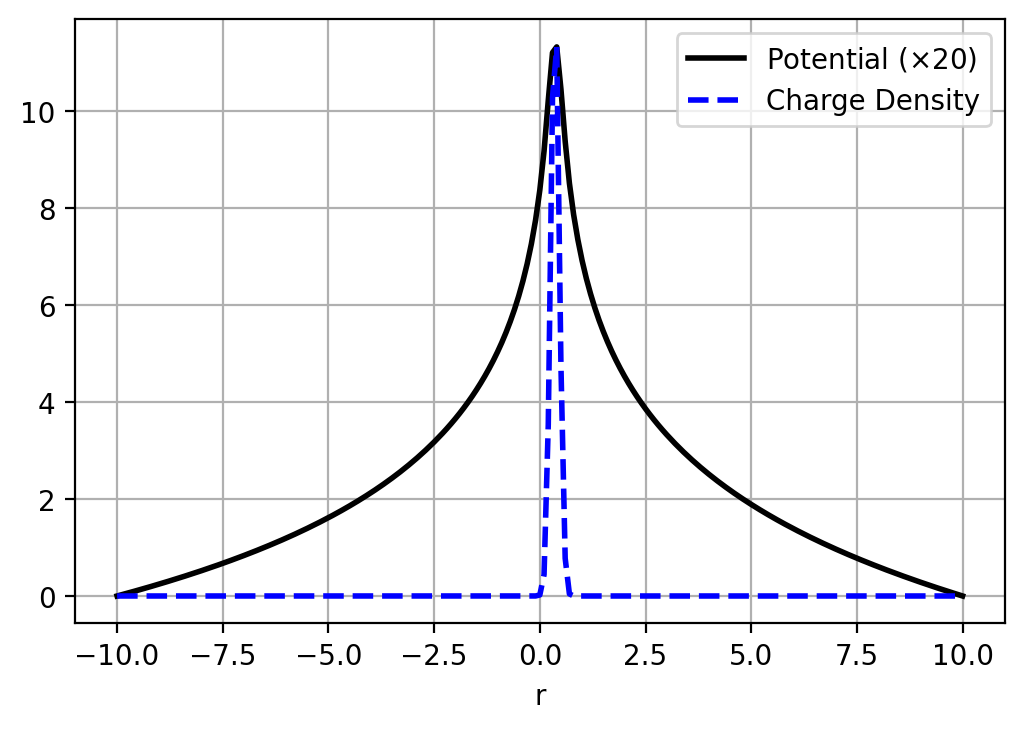

In [19]:
# Make the plot.
import matplotlib.pyplot as plt
fig = plt.figure(dpi=200)
plt.plot(r, scale_factor*v_values, "k", linewidth=2, label="Potential ($\\times %.0f$)" % scale_factor)
plt.plot(r, rho_values, "b--", linewidth = 2, label="Charge Density")
plt.grid(True)
plt.xlabel("r")
plt.legend()